In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import keras
import tensorflow as tf

from statsmodels.nonparametric.smoothers_lowess import lowess
from numpy import array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import metrics
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.layers import Conv1D, MaxPooling1D, Flatten, InputLayer, Dense
from tensorflow.keras.layers import LeakyReLU, PReLU
from keras.models import Sequential

In [83]:
# Load the dataset
dataset = r"D:\Documents\MASTER OF DATA SCIENCE\Research Project\Dataset\DATA SCIENCE PROJECT DATASET (CLEANED).xlsx"
df = pd.read_excel(dataset).reset_index(drop=True)
# df

In [84]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Day'])

# Include only numerical variables
numeric_df = df.select_dtypes(include=['number']).drop(['Year'], axis='columns', inplace=False)

In [85]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(numeric_df)

In [86]:
features = data_scaled[:, 1:]
target = data_scaled[:,0]

In [87]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# # Reshape the target
# y_train = y_train.reshape(len(y_train), 1)
# y_test = y_test.reshape(len(y_test), 1)

print(f'Train dataset shape: {x_train.shape}')
print(f'Target train dataset shape: {y_train.shape}')
print(f'Test dataset shape: {x_test.shape}')
print(f'Target test dataset shape: {y_test.shape}')

Train dataset shape: (1276, 12)
Target train dataset shape: (1276,)
Test dataset shape: (548, 12)
Target test dataset shape: (548,)


In [88]:
time_steps = 7
num_features = 12
batch_size = 32

train_generator = TimeseriesGenerator(x_train, y_train, length=time_steps, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=time_steps, sampling_rate=1, batch_size=batch_size)

In [89]:
initializer = tf.keras.initializers.HeUniform()

In [ ]:
cnn_lstm = keras.models.Sequential(
    [
        # Input Layer
        keras.layers.InputLayer(shape=(time_steps, num_features), name='Input_Layer'),

        # CNN Layers
        keras.layers.Conv1D(filters=16, activation='relu', kernel_size=3, padding='same', kernel_initializer=initializer, name='Convolutional_Layer_1'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling1D(pool_size=2, strides=2, name='Max_Pooling_Layer_1'),  # Reduces time steps
        
        # Fully Connected Layer
        keras.layers.Dense(25, activation='relu',kernel_initializer=initializer, name='CNN_Fully_Connected_Layer_1'),
        keras.layers.BatchNormalization(),

        # LSTM Layer (Input is still 3D: batch_size, time_steps, features)
        keras.layers.LSTM(50, activation='relu', kernel_initializer=initializer, name='LSTM_Layer_1'),
        keras.layers.BatchNormalization(),

        # Output Layer
        keras.layers.Dense(1, name='Output')
    ],
    name='CNNLSTM_Model'
)

In [92]:
cnn_lstm.summary()

Model: "CNNLSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Convolutional_Layer_1 (Conv1D)  │ (None, 7, 16)          │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling_Layer_1             │ (None, 3, 16)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Fully_Connected_Layer_1     │ (None, 3, 25)          │           425 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_1 (LSTM)             │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,632 (64.97 KB)

 Trainable params: 16,450 (64.26 KB)

 Non-trainable params: 182 (728.00 B)

In [96]:
# Compile the model
opt = keras.optimizers.SGD(learning_rate=0.001)
cnn_lstm.compile(optimizer=opt, loss="mse")

# Fit the model
epochs = 100
history = cnn_lstm.fit(train_generator, validation_data=test_generator, epochs=epochs, shuffle=False)

Epoch 1/100


c:\Users\User\anaconda3\envs\DSC790_DSProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3789 - val_loss: 0.8208
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7112 - val_loss: 0.7964
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3788 - val_loss: 0.8309
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1835 - val_loss: 0.8805
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0554 - val_loss: 0.9320
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9635 - val_loss: 0.9781
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8936 - val_loss: 1.0163
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8386 - val_loss: 1.0449
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7945 - val_loss: 1.0633
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7584 - val_loss: 1.0710
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7278 - val_loss: 1.0705
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7019 - val_l

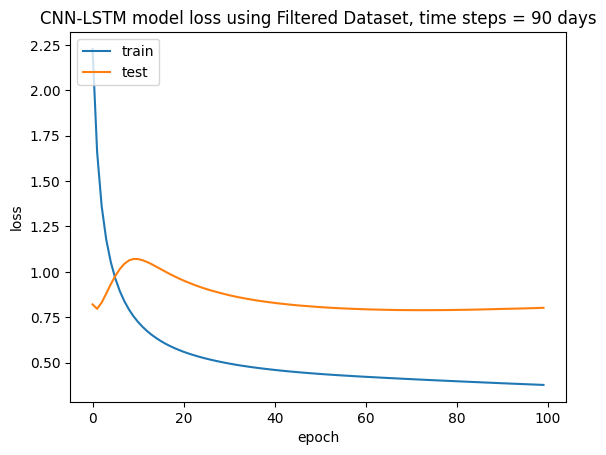

In [97]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-LSTM model loss using Filtered Dataset, time steps = 90 days')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Make predictions
predictions = cnn_lstm.predict(test_generator)  # Shape (n_samples, 1)

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_test - predictions))

#  Mean Squared Error (MSE)
mse = np.mean((y_test - predictions) ** 2)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))

# Print metrics
print(f"Final Mean Absolute Error (MAE): {round(mae, 3)}")
print(f"Mean Squared Error (MSE): {round(mse, 3)}")
print(f"Final Root Mean Square Error (RMSE): {round(rmse, 3)}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Final Mean Absolute Error (MAE): 0.693
Mean Squared Error (MSE): 0.778
Final Root Mean Square Error (RMSE): 0.882


In [99]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[time_steps:])], axis=1)
rev_trans = scaler.inverse_transform(df_pred)

In [100]:
rev_trans.shape

(541, 13)

In [101]:
df_final = df[predictions.shape[0]*-1:]
df_final.count()

Day                                                   541
Month                                                 541
Year                                                  541
Power Generation (MW)                                 541
Precipitation (mm)                                    541
Minimum Temperature (deg C)                           541
Maximum Temperature (deg C)                           541
Mean Temperature (deg C)                              541
Mean Dew Point Temperature (dec C)                    541
Hargreaves Potential Evaporation (mm)                 541
Potential Water Deficit (PPT- Hargreaves PET) (mm)    541
Wind Speed (m/s)                                      541
Eastward Wind Component (m/s)                         541
Northward Wind Component (m/s)                        541
Sea Level Pressure (kPa)                              541
Surface Pressure (kPa)                                541
dtype: int64

In [102]:
# Use .loc to explicitly assign values in the 'Forecasted Power Generation' column
df_final = df_final.copy()
df_final.loc[:, 'Forecasted Power Generation'] = rev_trans[:, 0]
# df_final

<Axes: title={'center': 'Hydropower Generation Forecasting Result Using CNN-LSTM Model'}>

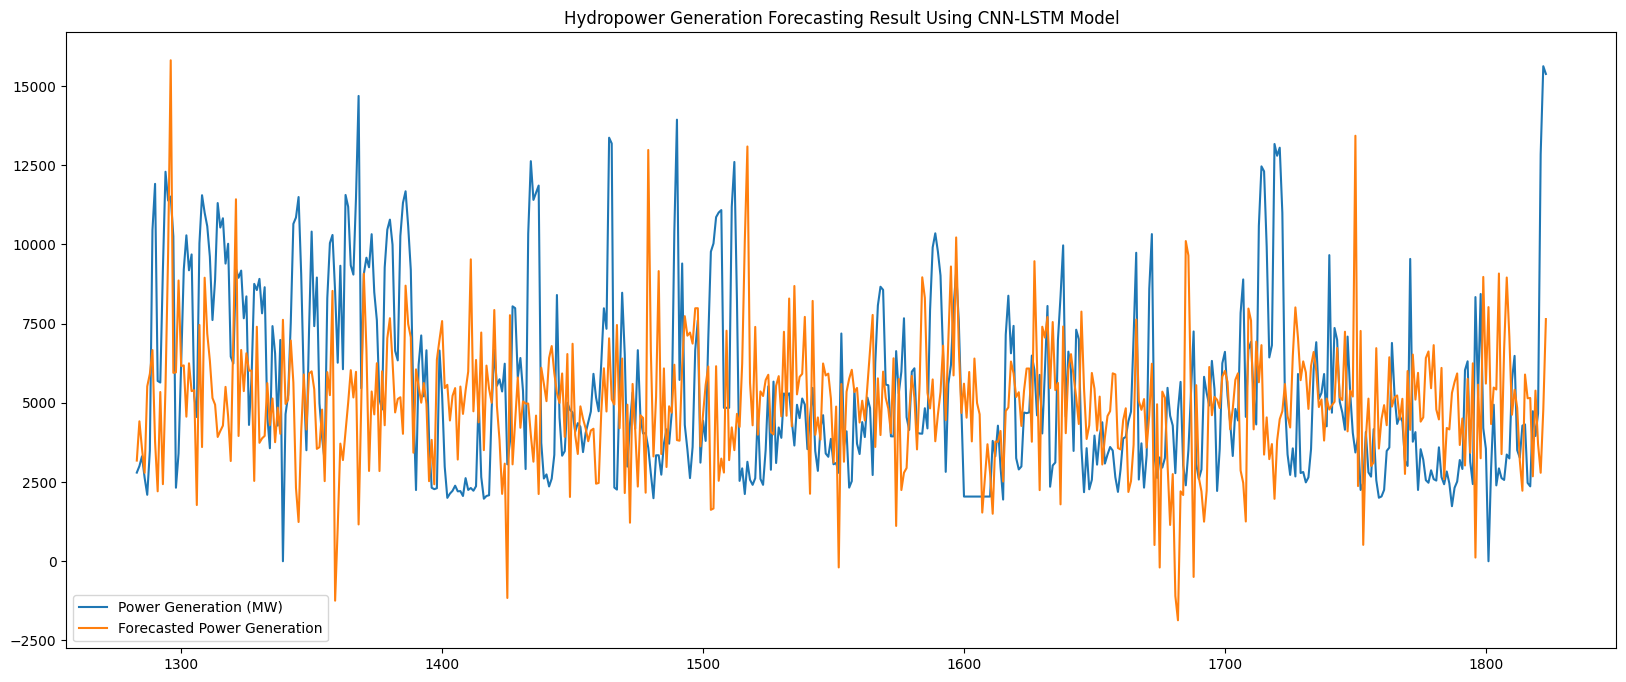

In [103]:
df_final[['Power Generation (MW)', 'Forecasted Power Generation']].plot(figsize=(20,8), title='Hydropower Generation Forecasting Result Using CNN-LSTM Model')